<a href="https://colab.research.google.com/github/wel51x/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/LS_DS2_233_Quantile_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [6]:
!pip3 install seaborn -U

    100% |████████████████████████████████| 215kB 20.9MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [1]:
!pip3 install statsmodels -U

    100% |████████████████████████████████| 7.4MB 4.3MB/s 
  Found existing installation: statsmodels 0.8.0
    Uninstalling statsmodels-0.8.0:
      Successfully uninstalled statsmodels-0.8.0


In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import seaborn as sns

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

In [0]:
df = df.dropna()

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [2]:
bwt_df = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt_df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [4]:
bwt_df.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


In [9]:
bwt_df.shape

(1174, 7)

In [8]:
# TODO - your work here! Also, add text cells for written questions.
bwt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 7 columns):
bwt          1174 non-null int64
gestation    1174 non-null int64
parity       1174 non-null int64
age          1174 non-null int64
height       1174 non-null int64
weight       1174 non-null int64
smoke        1174 non-null int64
dtypes: int64(7)
memory usage: 64.3 KB


In [20]:
bwt_df.corr()

,bwt,gestation,parity,age,height,weight,smoke
bwt,1.000000,0.407543,-0.043908,0.026983,0.203704,0.155923,-0.246800
gestation,0.407543,1.000000,0.080916,-0.053425,0.070470,0.023655,-0.060267
parity,-0.043908,0.080916,1.000000,-0.351041,0.043543,-0.096362,-0.009599
age,0.026983,-0.053425,-0.351041,1.000000,-0.006453,0.147322,-0.067772
height,0.203704,0.070470,0.043543,-0.006453,1.000000,0.435287,0.017507
weight,0.155923,0.023655,-0.096362,0.147322,0.435287,1.000000,-0.060281
smoke,-0.246800,-0.060267,-0.009599,-0.067772,0.017507,-0.060281,1.000000


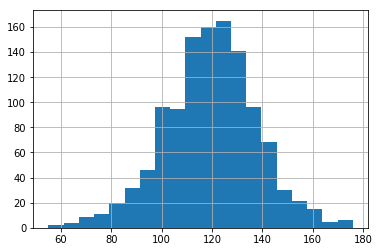

In [3]:
# no nulls, let's plot bwt
bwt_df['bwt'].hist(bins=20)

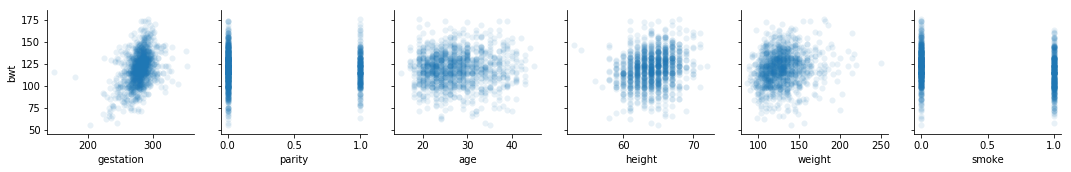

In [5]:
sns.pairplot(data=bwt_df, y_vars=['bwt'], x_vars=bwt_df.columns.drop(['bwt']), plot_kws={'alpha': 0.1, 'linewidth':0})

In [6]:
# run a quick linear regression
model = LinearRegression()

y = bwt_df['bwt']
X = bwt_df.drop('bwt', axis='columns')

model.fit(X, y)

model.score(X, y)

0.2579534937842991

In [7]:
df_non_smoker = bwt_df[(bwt_df['smoke'] < 1)]
df_smoker = bwt_df[(bwt_df['smoke'] > 0)]
print ("Smokers shape:", df_smoker.shape, "birthweight:", df_smoker.bwt.mean(),
       "\nNon-smokers", df_non_smoker.shape, "birthweight:", df_non_smoker.bwt.mean())


Smokers shape: (459, 7) birthweight: 113.81917211328977 
Non-smokers (715, 7) birthweight: 123.08531468531469


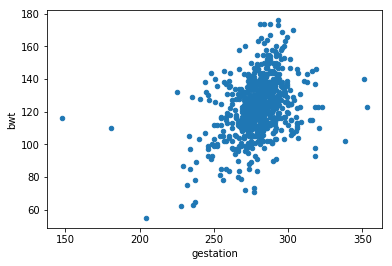

In [8]:
df_non_smoker.plot('gestation', 'bwt', kind='scatter')

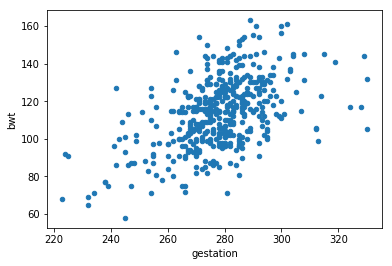

In [9]:
df_smoker.plot('gestation', 'bwt', kind='scatter')

In [10]:
lo_weight = ((bwt_df.bwt.values < 90).sum() / bwt_df.shape[0])
lo_weight_non_smoker = ((df_non_smoker.bwt.values < 90).sum() / df_non_smoker.shape[0])
lo_weight_smoker = ((df_smoker.bwt.values < 90).sum() / df_smoker.shape[0])
print("Percent of births under 90:", lo_weight * 100)
print("Percent of non-smoker births under 90:", lo_weight_non_smoker * 100)
print("Percent of smoker births under 90:", lo_weight_smoker * 100)

Percent of births under 90: 5.45144804088586
Percent of non-smoker births under 90: 3.3566433566433567
Percent of smoker births under 90: 8.714596949891067


In [11]:
quant_formula = 'bwt ~ ' + ' + '.join(bwt_df.drop('bwt', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=bwt_df)
quant_reg = quant_mod.fit(q = lo_weight)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2004
Model:                       QuantReg   Bandwidth:                       6.261
Method:                 Least Squares   Sparsity:                        132.7
Date:                Thu, 28 Feb 2019   No. Observations:                 1174
Time:                        14:08:00   Df Residuals:                     1167
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -96.3832     32.010     -3.011      0.003    -159.187     -33.580
gestation      0.4806      0.089      5.411      0.000       0.306       0.655
parity        -3.2591      2.347     -1.388      0.165      -7.865       1.347
age           -0.0882      0.170     -0.517      0.605      -0.423       0.246
height         1.2257      0.437      2.807      0.005       0.369       2.082
weight        -0.1193      0.057     -2.098      0.036      -0.231      -0.008
smoke         -8.6951      1.867     -4.656      0.000     -12.359      -5.031
==============================================================================

The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
quant_formula = 'bwt ~ ' + ' + '.join(df_non_smoker.drop(['bwt', 'smoke'], axis='columns').columns)
print(quant_formula)
print("Non-smokers:")
quant_mod = smf.quantreg(quant_formula, data=df_non_smoker)
quant_reg = quant_mod.fit(q = lo_weight_non_smoker)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight
Non-smokers:


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1740
Model:                       QuantReg   Bandwidth:                       7.798
Method:                 Least Squares   Sparsity:                        216.8
Date:                Thu, 28 Feb 2019   No. Observations:                  715
Time:                        14:08:04   Df Residuals:                      709
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -87.0308     67.950     -1.281      0.201    -220.438      46.377
gestation      0.4759      0.190      2.505      0.012       0.103       0.849
parity        -2.6626      3.929     -0.678      0.498     -10.376       5.051
age           -0.3430      0.274     -1.251      0.211      -0.881       0.195
height         1.1672      0.799      1.461      0.144      -0.401       2.736
weight        -0.1286      0.084     -1.534      0.125      -0.293       0.036
==============================================================================

The condition number is large, 9.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
quant_formula = 'bwt ~ ' + ' + '.join(df_smoker.drop(['bwt', 'smoke'], axis='columns').columns)
print(quant_formula)
print("Smokers:")
quant_mod = smf.quantreg(quant_formula, data=df_smoker)
quant_reg = quant_mod.fit(q = lo_weight_smoker)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight
Smokers:


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1980
Model:                       QuantReg   Bandwidth:                       8.449
Method:                 Least Squares   Sparsity:                        89.76
Date:                Thu, 28 Feb 2019   No. Observations:                  459
Time:                        14:08:10   Df Residuals:                      453
                                        Df Model:                            5
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -115.1206     37.838     -3.042      0.002    -189.480     -40.761
gestation      0.4824      0.114      4.217      0.000       0.258       0.707
parity        -0.7677      3.188     -0.241      0.810      -7.033       5.498
age           -0.0018      0.249     -0.007      0.994      -0.492       0.488
height         1.1261      0.517      2.179      0.030       0.111       2.142
weight         0.0085      0.080      0.106      0.915      -0.149       0.166
==============================================================================

The condition number is large, 9.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
quant_formula = 'bwt ~ gestation + parity + smoke'
quant_mod = smf.quantreg(quant_formula, data=bwt_df)
print(quant_formula)
#for quantile in range(50, 100):
for quantile in [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9.9]:
  quantile /= 10
  quant_reg = quant_mod.fit(q=quantile)
  print("At:", quantile, "==>> R2 =", quant_reg.prsquared)

bwt ~ gestation + parity + smoke
At: 0.01 ==>> R2 = 0.20565221927628563
At: 0.05 ==>> R2 = 0.18606712940177816
At: 0.1 ==>> R2 = 0.16890718547477934
At: 0.2 ==>> R2 = 0.1516581964546433
At: 0.3 ==>> R2 = 0.13721428537964708
At: 0.4 ==>> R2 = 0.1208183640621806
At: 0.5 ==>> R2 = 0.11046615979583752
At: 0.6 ==>> R2 = 0.10170131997555154
At: 0.7 ==>> R2 = 0.08998431807572671
At: 0.8 ==>> R2 = 0.08139582335822537
At: 0.9 ==>> R2 = 0.07665408530688889
At: 0.99 ==>> R2 = 0.11981663340327442


## I can only conclude by looking at the bwt vs gestation charts for smokers vs non-smokers that smoking negatively affects birthweight. Both birthweight and gestation periods tend lower for smokers.

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model